In [2]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import os
import glob

In [93]:
def ssd(vecs1, vecs2, window_size):
    # print(vecs1.shape , vecs1)
    # print(vecs2.shape, vecs2)
    vecs1 = vecs1.flatten().reshape((2*window_size+1)**2, 3).astype(int)
    # print(vecs1)
    vecs2 = vecs2.flatten().reshape((2*window_size+1)**2, 3).astype(int)
    # print(vecs2)
    
    output = np.sum([np.sum((x)**2) for x in (vecs1-vecs2)])

    return output

Looping
---

Testing approach where we loop over every pixel. Way too slow. Takes about 1 min to do the calculation for a single row of x values in the given image

In [ ]:

base_path  = os.getcwd() + "/Dataset/"
pathL = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'
pathR = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg'

print(base_path + pathL)

window_size = 1 ## This is not the size of the actual window, our window looks like this [window_size :pixel of interest: window_size], so the size of the whole window is (2*window size)+1


left = cv2.imread(base_path + pathL)
right = cv2.imread(base_path + pathR)

print("Shape before padding ", left.shape)
print("Shape before padding ", right.shape)

left = cv2.copyMakeBorder(left, window_size, window_size, window_size, window_size, cv2.BORDER_CONSTANT, None, value = 0)
right = cv2.copyMakeBorder(right, window_size, window_size, window_size, window_size, cv2.BORDER_CONSTANT, None, value = 0)


# plt.imshow(left)
# plt.axis('off')
# plt.show()
# plt.imshow(right)
# plt.axis('off')
# plt.show()


print("Shape after padding ", left.shape)
print("Shape after padding ", right.shape)

x = left.shape[1] 
y = left.shape[0]


disparity = []

for i_y in range(1,2):
# for i_y in range(window_size, y-window_size):

    print(i_y-window_size)


    right_line_nbhds = []

    print("Before right x nbhds created")
    ## Create all the pixel neighbourhoods for the line in the right image
    for i_x2 in range(window_size, x-window_size):
            
        nbhd_right_img = np.array(right[i_y-window_size:i_y+window_size+1, i_x2-window_size:i_x2+window_size+1,:]).astype(int) 
        right_line_nbhds.append(nbhd_right_img)

    print("After right x nbhds created")

    right_line_nbhds = np.array(right_line_nbhds)

    print("nbhds ",len(right_line_nbhds))

    ## For each x in the left image, compare it to every pixel neighbourhood in the right image (using SSD here) and take the smallest SSD
    for i_x in range(window_size, x-window_size):
        
        x_left = left[i_y-window_size:i_y + window_size + 1,i_x - window_size:i_x+window_size+1,:] ## Left pixel neighbourhood
        nbhd_ssd = np.array([ssd(x_left,r, window_size) for r in right_line_nbhds]) ## Generate all SSDs for left pixel (1 per right pixel nbhd) 
        match_r_img = np.argmin(nbhd_ssd) ## Take minimum ssd as the closest match       
        pixel_disparity = (i_x - window_size) - match_r_img ## Calculate disparity

        # print(i_x, match_r_img,pixel_disparity, nbhd_ssd )
        # print(i_x, match_r_img)

        disparity.append(pixel_disparity)

    
print(disparity)

        




Vectorized Version 1
--- 

This brings the time down to about 2.5 seconds per row. Still not fast enough.

The way this method works is that for a given row and all the neighbourhoods related to that row it turns them into a vector and performs vector operations to calculate our disparity. 

The next step is to vectorize the whole image and perform these operations

In [109]:

base_path  = os.getcwd() + "/Dataset/"
pathL = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'
pathR = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg'

print(base_path + pathL)

window_size = 1 ## This is not the size of the actual window, our window looks like this [window_size :pixel of interest: window_size], so the size of the whole window is (2*window size)+1


left = cv2.imread(base_path + pathL)
right = cv2.imread(base_path + pathR)

print("Shape before padding ", left.shape)
print("Shape before padding ", right.shape)

left = cv2.copyMakeBorder(left, window_size, window_size, window_size, window_size, cv2.BORDER_CONSTANT, None, value = 0)
right = cv2.copyMakeBorder(right, window_size, window_size, window_size, window_size, cv2.BORDER_CONSTANT, None, value = 0)



print("Shape after padding ", left.shape)
print("Shape after padding ", right.shape)

x = left.shape[1] 
y = left.shape[0]

# print(window_size, x-window_size)

disparity = []

for i_y in range(1,10):
# for i_y in range(window_size, y-window_size):
    print(i_y-window_size)



    right_line_nbhds = []
    # print("Before right x nbhds created")

    for i_x2 in range(window_size, x-window_size):

    # for i_x2 in range (1,3):

        nbhd_right_img = np.array(right[i_y-window_size:i_y+window_size+1, i_x2-window_size:i_x2+window_size+1,:]).astype(int).flatten() ##.reshape(1,window_size**2)
        # print("right nbhd ", nbhd_right_img)
        right_line_nbhds.append(nbhd_right_img)

    # print("After right x nbhds created")
    
    # print("right ", right_line_nbhds[0:5])

    right_line_nbhds = np.array(right_line_nbhds).flatten()

    right_line_nbhds = np.tile(right_line_nbhds, x-2*window_size)


    left_line_nbhds = []

    # print("Before left x nbhds created")


    for i_x2 in range (window_size, x - window_size):

    # for i_x2 in range (1,3):

        nbhd_left_img = np.array(left[i_y-window_size:i_y+window_size+1, i_x2-window_size:i_x2+window_size+1,:]).astype(int).flatten()
        
        # print("left nbhd ", nbhd_left_img)

        nbhd_left_img = np.tile(nbhd_left_img, x - 2*window_size)

        left_line_nbhds.append(nbhd_left_img)


    left_line_nbhds = np.array(left_line_nbhds).flatten()

    # print("left " ,left_line_nbhds[0:5])

    # left_line_nbhds = np.array(left_line_nbhds).flatten()

    # left_line_nbhds = np.repeat(left_line_nbhds, x)
    # right_line_nbhds = np.tile(right_line_nbhds, (x,1))


    # print("After left x nbhds created")

    # print("right ", right_line_nbhds[0:5])
    # print("left " ,left_line_nbhds)

    # print("right ", right_line_nbhds.shape)
    # print("left " ,left_line_nbhds.shape)

    # print("sub ",(left_line_nbhds-right_line_nbhds)[0:54])

    # print("sub2 ",((left_line_nbhds-right_line_nbhds)**2)[0:54])

    # # print("sub2 ",((left_line_nbhds-right_line_nbhds)**2).flatten()[0:27])

    flat = ((left_line_nbhds-right_line_nbhds)**2)

    # print(flat.shape)

    # print(flat[0:27])
    # print(flat[27:54])
    # print(flat[54:81])

    # print("flat ", flat[0:27].sum())
    # print("flat ", flat[27:54].sum())
    # print("flat ", flat[54:81].sum())

    # print(len(flat)/27)

    step = ((2*window_size+1)**2)*3 ## Number of pixels in window * number of colour channels(3)
    waga = np.array([flat[i:i+step].sum() for i in range(0,len(flat), 27)])
    # print(waga.shape)
    # np.argmin(flat) 
    ssd = np.array([np.argmin(waga[i:i + (x - 2*window_size)]) for i in range (0, (x - 2*window_size)**2, (x - 2*window_size) )])

    # print(ssd.shape)

    # print(ssd)
    row_disparity = ssd - np.linspace(0, x - (2*window_size + 1) ,num = (x-2*window_size)).astype(int)
    disparity.append(row_disparity)
 


    

    # print(waga)

    # for l_x in left_line_nbhds:


    


    # print("nbhds ",len(right_line_nbhds))

    # # for i_x in range(10):
    # for i_x in range(window_size, x-window_size):
        
        

    #     x_left = left[i_y-window_size:i_y + window_size + 1,i_x - window_size:i_x+window_size+1,:]

    #     # nbhd_right_img = right[i_y-window_size:i_y+window_size+1, i_x-window_size:i_x+window_size+1,:] ## nbhd = neighbourhood

    #     nbhd_ssd = np.array([ssd(x_left,r, window_size) for r in right_line_nbhds]) ## Generate ssd for neighbourhood



    #     match_r_img = np.argmin(nbhd_ssd) ## Take minimum ssd as the closest match 
    #     pixel_disparity = (i_x - window_size) - match_r_img ## Calculate disparity
        
    #     print(i_x)

    #     disparity.append(pixel_disparity)


        
disparity




/Users/oliverbestel/Desktop/Documents/Work/COMP90086/Tuts/P1/CV_Project/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg
Shape before padding  (400, 881, 3)
Shape before padding  (400, 881, 3)
Shape after padding  (402, 883, 3)
Shape after padding  (402, 883, 3)
0
1
2
3
4
5
6
7
8


[array([   0,   65,   65,   65,   -3,   -4,   -5,   -6,   -7,   -8,   -9,
          27,   26,   25,   24,   23,   22,   21,   20,  -17,  -17,  -16,
          -8,  -16,  -11,  -13,    9,  -23,    9,  -18,    6,    6,    6,
           5,  104,  103,  102,  101,    2,   29,   28,    0,    0,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -2,   -1,   -2,   -2,   -2,
          -2,   -2,   -2,   -2,   -1,   -2,   -2,   -2,   -2,   -2,   -2,
          -2,   -2,   -3,   -2,   -3,   -3,  -71,  -72,  -73,  -74,  -75,
          -7,   60,   47,   46,   44,   43,    0,   -1,   24,  -51,  -52,
         -53,  -53,  -54,  -55,  -56,  -57,  -57,  -59,  -60,  -61,  -61,
         -87,  -88,  -88,  -89,  -90,  -91,  -92,  -92,  -93,  -94,  -73,
         -74,  -73,  -74,  -75,  -76,   11,   10,    9,    8,  -85,  -10,
         510,  510,  -10,  -10,  -10,  -10,  224,   -2,   -3,    6,    6,
          -7,   -7,  -48, -117, -100,  -98,  -99,  -99,   -2,   -1,   -2,
          -2,   -1,   -1,   -1,   -1, 

In [ ]:
def create_neighbourhood(pixel_x, pixel_y, img, window_size):

    nbhd = np.array(right[pixel_y-window_size:pixel_y+window_size+1, pixel_x-window_size:pixel_x+window_size+1,:])
    
    return nbhd

    

# def create_all_neighbourhoods(img, padding):


    

We now try to compute the disparity map without running along horizontals. To do this, conceptually, we first superimpose the images, and subtract the left from the right. For each pixel in the result, the neighbourhood around it is one we would have to calculate anyway. For every pixel in the result, we compute the neighbourhood around it in, and store it as the minimum SSD/ maximum CCD in an array with every pixel(same resolution as original).

We then shift the right image along one pixel, subtract it, and repeat this process. In this fashion, we can accomplish the shifting window by doing fast tensor operations once per pixel in the width of the image.

 When the images are superimposed, we get all the neighbourhoods where we assume the disparity is 0. When we shift the right image to the right by one, we are getting all the neighbourhoods where we assume the disparity is 1. Since we only care about the max/min value of CCD/SSD, we can just store the disparity and the found max/min value. So, we only have to compute each neighbourhood once, whereas with the previous method there is a lot of overlap. And we only have to store an array the size of the image, with two channels instead of 3. We are effectively iterating through disparities, rather than iterating through the images.
 
A fundamental assumption here is that, since the images are parallel, a pixel in the right image must be at least as far left in it as it is in the left image, since we have moved right between cameras. That is, the disparity must be non-negative. Because of this, we can start with the images overlapping, at disparity 0, instead of the rightmost part of the right image overlapping with the leftmost part of the left image, which would be maximum negative disparity.

Also, need to figure out how to handle the borders, since setting them to 0 will make the SSD really small since the difference will be 0. Assuming we force the borders to be 0

In [44]:
def SSD(neighbourhood):
    return np.sum((neighbourhood.flatten())**2)

In [45]:
def neighbourhood(img, x, y, radius):
    return img[x-radius:x+radius+1,y-radius:y+radius+1]

In [53]:
def compute_neighbourhoods(dif_img, radius, window_func):
    
    values = []
    
    # Loop through every pixel except those in the padding
    for row in range(radius, dif_img.shape[0]-radius):
        values.append([])
        for col in range(radius, dif_img.shape[1]-radius):
            # Calculate the value for this row, column
            values[row-radius].append(window_func(neighbourhood(dif_img, row, col, radius)))
        
    return np.array(values)
    

In [57]:
def image_shift(left_img, right_img, radius, window_func=SSD):
    
    # Pad the borders of the left image
    left  = cv2.copyMakeBorder(left_img,  radius, radius, radius, radius, cv2.BORDER_CONSTANT, None, value = 0)
    # We don't need extra padding to the right of the right image, we just only subtract the left where it overlaps
    right = cv2.copyMakeBorder(right_img, radius, radius, radius, radius, cv2.BORDER_CONSTANT, None, value = 0)
    # AFTER SHIFTING AND SUBTRACTING, REMEMBER TO SET ALL OF THE LEFT PART OF THE RESULT THAT IS LEFT OF WHERE THE 0TH PIXEL
    # OF THE LEFT IS MINUSED TO 0, SO THAT WHEN WE TAKE THE NEIGHBOURHOOD IT DOESN'T TAKE IN THE ORIGINAL VALUES.
    
    # Initialise best values
    min_SSDS = []
    disparities = np.zeros(left.shape)
    
    for disparity in range(left_img.shape[1]):
        print(disparity)
        # Get the difference between the images with this shift
        result = right[:,:right.shape[1]-disparity,:] - left[:,disparity:,:]
        # Enforce that the left padding of the right image stays 0
        # It doesn't make sense to compute the difference outside of the overlap
        result[:,:radius] = np.zeros(result[:,:radius].shape)
        # Enforce the same thing for the right padding of the left image
        result[:,-(radius+disparity):] = np.zeros(result[:,-(radius+disparity):].shape)
        
        # For evey valid pixel, compute the value of the window function for its neighbourhood
        values = compute_neighbourhoods(result[:, :result.shape[1]-disparity], radius, window_func)
        
        # Now we compare these values to our stored values, and update them if they're better
        # If it's the first iteration, we just use what we just got as our best
        if (disparity==0):
            min_SSDS = values
        else:
            for row in range(values.shape[0]):
                for col in range(values.shape[1]):
                    if (values[row][col] < min_SSDS[row][col]):
                        min_SSDS[row][col] = values[row][col]
                        disparities[row][col] = disparity
        
    return disparities
    
    

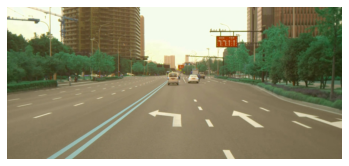

In [58]:
base_path  = os.getcwd() + "/Dataset/"
pathL = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'
pathR = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg'

left_img = cv2.imread(base_path + pathL)
right_img = cv2.imread(base_path + pathR)
plt.imshow(right_img)
plt.axis('off')
plt.show()
# plt.imshow(right)
# plt.axis('off')
# plt.show()

In [59]:
disparity_map = image_shift(left_img, right_img, 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


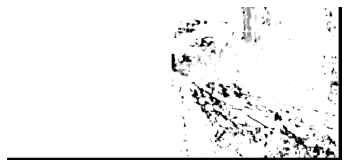

In [62]:
plt.imshow(disparity_map*255/np.max(disparity_map))
plt.axis('off')
plt.show()

In [68]:
disparity_map.shape

(406, 887, 3)